## Install Dependencies

First of all you have to install the necessary libraries for YOLOv8 (ultralytics), DeepSORT, and other utilities like OpenCV.



To install the required libraries, I will use pip install commands in a code block.

-Ultralytics is being used since its the repository for the YOLO model we will be using.

-OpenCV is a crucial library since it deals with video and image processing (in charge of our boundning boxes and output video)


In [58]:
import sys
!{sys.executable} -m pip install ultralytics
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install ipython

Core libraries re-installed successfully. DeepSORT installation will be addressed if needed.


Its a hassle to install deepsort without having the core AKA pytorch so this is the installation before we install deepsort. Here we are verifying that pytorch is installed and is correctly configured to use your system's GPU.

In [60]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! Installing PyTorch with CUDA support.")
    cuda_version = torch.version.cuda
    print(f"Detected CUDA version: {cuda_version}")
    # The exact command depends on the PyTorch version and CUDA version.
    # For Colab, a common command for the latest stable version would be:
    # !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
    # (replace cu121 with your detected CUDA version if different)
    print("You may need to run a specific command based on your exact CUDA version.")
    print("Refer to the official PyTorch installation guide for the precise command:")
    print("https://pytorch.org/get-started/locally/")
else:
    print("CUDA is not available. Installing PyTorch CPU version.")
    # Command for CPU-only version
    !pip install torch torchvision torchaudio

print("PyTorch installation process initiated. Please follow any further instructions from the PyTorch website for specific CUDA versions if needed.")


CUDA is available! Installing PyTorch with CUDA support.
Detected CUDA version: 12.6
You may need to run a specific command based on your exact CUDA version.
Refer to the official PyTorch installation guide for the precise command:
https://pytorch.org/get-started/locally/
PyTorch installation process initiated. Please follow any further instructions from the PyTorch website for specific CUDA versions if needed.


In [59]:
import torch

if torch.cuda.is_available():
    print("PyTorch is successfully installed with CUDA support!")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(0)}")

    # Test a simple operation on the GPU
    a = torch.tensor([1.0, 2.0, 3.0]).cuda()
    b = torch.tensor([4.0, 5.0, 6.0]).cuda()
    c = a + b
    print(f"Sample tensor operation on GPU: {c}")
else:
    print("PyTorch CUDA is NOT available or not correctly installed.")
    print("Please ensure you have a CUDA-enabled GPU and that PyTorch was installed with CUDA support.")


PyTorch is successfully installed with CUDA support!
CUDA version: 12.6
Number of GPUs available: 1
Current GPU device name: Tesla T4
Sample tensor operation on GPU: tensor([5., 7., 9.], device='cuda:0')


This part is just a regular pytorvch installation

In [61]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


Now we since we installed pytorch we can install deepsort to use with our model. If you dont install pytorch first it will have incompatability errors.

In [62]:
import sys
!{sys.executable} -m pip install deep-sort-realtime

print("DeepSORT library (deep-sort-realtime) installed successfully.")

DeepSORT library (deep-sort-realtime) installed successfully.


This code block is initializing the DeepSORT tracker that we will be using for our human tracking model.


1.   max-iou-distance = helps maintain track identity even if detections are slightly noisy.
2.   max-age = this parameter determines how many consecutive frames a track can go without being associated with a new detection before it's deleted.
3.   n_inint = This parameter specifies the number of consecutive detections required to establish a new confirmed track.





In [63]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Initialize DeepSORT tracker with custom parameters
tracker = DeepSort(max_iou_distance=0.8, max_age=10, n_init=3) # Adjusted parameters

print("DeepSORT tracker initialized successfully with adjusted parameters.")

DeepSORT tracker initialized successfully with adjusted parameters.


## Loading the models and initializing the tracker

Load the pre-trained YOLOv8 model for object detection and prepare for tracking.


**Reasoning**:
We load ultralytics once again for safety and security even though its installed in the first code block.We the instantiate it with the desired model weights, which will be 'yolov8n.pt'.



In [64]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # Using 'yolov8n.pt' for its balance of speed and accuracy

print("YOLOv8 model loaded successfully.")

YOLOv8 model loaded successfully.


## Process Video for Tracking

Next we will make sure our model reads the uploaded video file, frame by frame. For each frame, it will perform object detection using YOLOv8 and then apply tracking to the detected humans. Draw bounding boxes and unique IDs on the tracked objects.


**Reasoning**:
I need to define the input and output video paths, import `cv2`, open the input video, set up the `VideoWriter`, and then iterate through each frame to perform object detection and tracking using the pre-trained YOLOv8 model. The `model.track` method will be used for tracking, focusing on the 'person' class, and annotations will be drawn on the frames before saving to an output video.



## **##IMPORTANT MAKE SURE TO NAME YOUR VIDEO input_video and that its also a mp4 format!**

In [65]:
import cv2
import os
from ultralytics import YOLO

# Ensure the DeepSort tracker and YOLOv8 model are already loaded/initialized from previous steps

# Load a pre-trained YOLOv8 model (re-added for robustness)
model = YOLO('yolov8n.pt')  # Using 'yolov8n.pt' for its balance of speed and accuracy

# Define input and output video paths
input_video_path = 'input_video.mp4' # This should be the path to your uploaded video
output_video_path = 'output_video_deepsort.mp4'

# Ensure the input video exists or prompt user to upload
# This logic was already handled in a previous cell, but re-including for completeness
# if not os.path.exists(input_video_path):
#     print(f"'{input_video_path}' not found. Please upload the video file.")
#     uploaded = files.upload()
#     if not uploaded:
#         raise FileNotFoundError("No file was uploaded. Please upload a video file.")
#     input_video_path = list(uploaded.keys())[0]
#     print(f"Using uploaded file: '{input_video_path}'")
# else:
#     print(f"Using existing file: '{input_video_path}'")

# Open the video file
video_cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

print(f"Processing video: {input_video_path} with DeepSORT")
print(f"Output video will be saved to: {output_video_path}")

frame_count = 0
while video_cap.isOpened():
    ret, frame = video_cap.read()
    if not ret:
        break

    # 7a. Perform object detection using the pre-loaded YOLOv8 model
    # Only detect 'person' class (class ID 0 in COCO dataset)
    results = model.predict(frame, classes=[0], conf=0.5, iou=0.5)

    detections = []
    if results[0].boxes is not None:
        # 7b. Filter detections to only include 'person' class
        # 7c. Extract bounding boxes (xmin, ymin, xmax, ymax) and confidence scores
        # Convert bounding box coordinates to the format expected by DeepSORT (top-left x, top-left y, width, height)
        for box in results[0].boxes.data:
            xmin, ymin, xmax, ymax, conf, class_id = box.tolist()
            # DeepSORT expects (x, y, w, h)
            w = xmax - xmin
            h = ymax - ymin
            detections.append(([xmin, ymin, w, h], conf, class_id))

    # 7d. Update the DeepSORT tracker
    tracks = tracker.update_tracks(detections, frame=frame)

    # Create a copy of the frame for drawing annotations
    annotated_frame = frame.copy()

    # 7e. Iterate through the updated tracks from DeepSORT and draw annotations
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()

        # Generate a unique color for each track ID
        # Using a simple hash based on track_id for color generation
        color_seed = int(str(hash(track_id))[-3:]) # Use last 3 digits of hash for color variation
        b = (color_seed * 17) % 255
        g = (color_seed * 37) % 255
        r = (color_seed * 53) % 255
        track_color = (b, g, r)

        # Bounding box coordinates
        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])

        # Draw bounding box
        cv2.rectangle(annotated_frame, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), track_color, 2)

        # Put track ID text
        cv2.putText(annotated_frame, f"ID: {track_id}", (bbox_xmin, bbox_ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, track_color, 2)

    # 7f. Write the annotated frame to the output video
    out.write(annotated_frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"Processed {frame_count} frames...")

# 8. Release the video capture and writer objects
video_cap.release()
out.release()
cv2.destroyAllWindows()

# 9. Print a message indicating completion
print("Video processing complete with DeepSORT. Output saved.")


Processing video: input_video.mp4 with DeepSORT
Output video will be saved to: output_video_deepsort.mp4

0: 384x640 1 person, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.2ms
Speed: 1.7ms preprocess, 6.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 38

The next code block is similar to the last one but here we are analyzing the tracking data.It will collect all our tracking data and make it into a list.

As you can see the end section of

TRACKING ANALLYSIS RESULTS
which gives us the total uniqe id's/ people it detected in the video.


In [71]:
import cv2
import os
from ultralytics import YOLO
import pandas as pd
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. Re-initialize the DeepSort tracker and load the YOLOv8 model
tracker = DeepSort(max_iou_distance=0.8, max_age=10, n_init=3) # Adjusted parameters
model = YOLO('yolov8n.pt')  # Using 'yolov8n.pt' for its balance of speed and accuracy

# Define input and output video paths
input_video_path = 'input_video.mp4'
output_video_path_analysis = 'output_video_deepsort_analysis.mp4'

# 2. Create an empty list to store tracking information
tracking_results_data = []

# Open the video file
video_cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_video_path_analysis, fourcc, fps, (frame_width, frame_height))

print(f"Processing video for data collection: {input_video_path}")
print(f"Output video with annotations will be saved to: {output_video_path_analysis}")

frame_count = 0
while video_cap.isOpened():
    ret, frame = video_cap.read()
    if not ret:
        break

    # 4a. Perform object detection using the pre-loaded YOLOv8 model
    # Only detect 'person' class (class ID 0 in COCO dataset)
    results = model.predict(frame, classes=[0], conf=0.5, iou=0.5)

    detections = []
    if results[0].boxes is not None:
        # 4b. Extract bounding boxes (xmin, ymin, xmax, ymax) and confidence scores
        # Convert bounding box coordinates to the format expected by DeepSORT (top-left x, top-left y, width, height)
        for box in results[0].boxes.data:
            xmin, ymin, xmax, ymax, conf, class_id = box.tolist()
            w = xmax - xmin
            h = ymax - ymin
            detections.append(([xmin, ymin, w, h], conf, class_id))

    # 4c. Update the DeepSORT tracker
    tracks = tracker.update_tracks(detections, frame=frame) # Pass frame for appearance feature extraction if enabled in DeepSort

    annotated_frame = frame.copy()

    # 4d. Iterate through the updated tracks and record data
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()

        # Record tracking data
        tracking_results_data.append({
            'frame_count': frame_count,
            'track_id': track_id,
            'bbox_xmin': ltrb[0],
            'bbox_ymin': ltrb[1],
            'bbox_xmax': ltrb[2],
            'bbox_ymax': ltrb[3]
        })

        # 4e. Draw bounding box
        color_seed = int(str(hash(track_id))[-3:]) # Use last 3 digits of hash for color variation
        b = (color_seed * 17) % 255
        g = (color_seed * 37) % 255
        r = (color_seed * 53) % 255
        track_color = (b, g, r)

        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        cv2.rectangle(annotated_frame, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), track_color, 2)
        cv2.putText(annotated_frame, f"ID: {track_id}", (bbox_xmin, bbox_ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, track_color, 2)

    # 4f. Write the annotated frame to the output video
    out.write(annotated_frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"Processed {frame_count} frames...")

# 5. Release the video capture and writer objects
video_cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing and data collection complete. Now analyzing tracking data.")

# 6. Convert the tracking_results_data list into a Pandas DataFrame
tracking_df = pd.DataFrame(tracking_results_data)

# 7. Calculate the total number of unique track_id values
total_unique_ids = tracking_df['track_id'].nunique()

# 8. For each unique track_id, count how many frames it appeared in to determine its track length.
# Then, calculate the average of these track lengths.
if not tracking_df.empty:
    track_lengths = tracking_df.groupby('track_id')['frame_count'].nunique()
    average_track_length = track_lengths.mean()
else:
    track_lengths = pd.Series()
    average_track_length = 0

# 9. Print the statistics
print(f"\n--- Tracking Analysis Results ---")
print(f"Total number of unique track IDs: {total_unique_ids}")
print(f"Average track length (number of frames an ID appeared): {average_track_length:.2f} frames")
print("Quantitative assessment of identity switches and fragmentation often requires more complex metrics or qualitative review, which will be addressed in a later step.")

Processing video for data collection: input_video.mp4
Output video with annotations will be saved to: output_video_deepsort_analysis.mp4

0: 384x640 1 person, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 0.5ms postprocess per image 

## Calculate Centroid Coordinates

This code block is calculating the center coordinates of each bounding box for every tracked person and adding these as new columns to the tracking_df. This in general makes it easier to analyze our boxes movement within the video.

In [72]:
tracking_df['center_x'] = (tracking_df['bbox_xmin'] + tracking_df['bbox_xmax']) / 2
tracking_df['center_y'] = (tracking_df['bbox_ymin'] + tracking_df['bbox_ymax']) / 2

print("Added 'center_x' and 'center_y' columns to tracking_df.")
print(tracking_df.head())

Added 'center_x' and 'center_y' columns to tracking_df.
   frame_count track_id   bbox_xmin   bbox_ymin   bbox_xmax   bbox_ymax  \
0            2        1  449.403569  424.812202  496.096174  554.239093   
1            3        1  450.018919  421.848193  496.386314  550.373637   
2            4        1  450.634269  418.884184  496.676454  546.508182   
3            5        1  451.249619  415.920176  496.966594  542.642726   
4            6        1  451.864969  412.956167  497.256735  538.777271   

     center_x    center_y  
0  472.749872  489.525648  
1  473.202617  486.110915  
2  473.655362  482.696183  
3  474.108107  479.281451  
4  474.560852  475.866719  


## Generate Tracking Path Plot

Here we visualize our tracking dataframe which allows you to see the paths of your bounding boxes in this case, the people in our video.


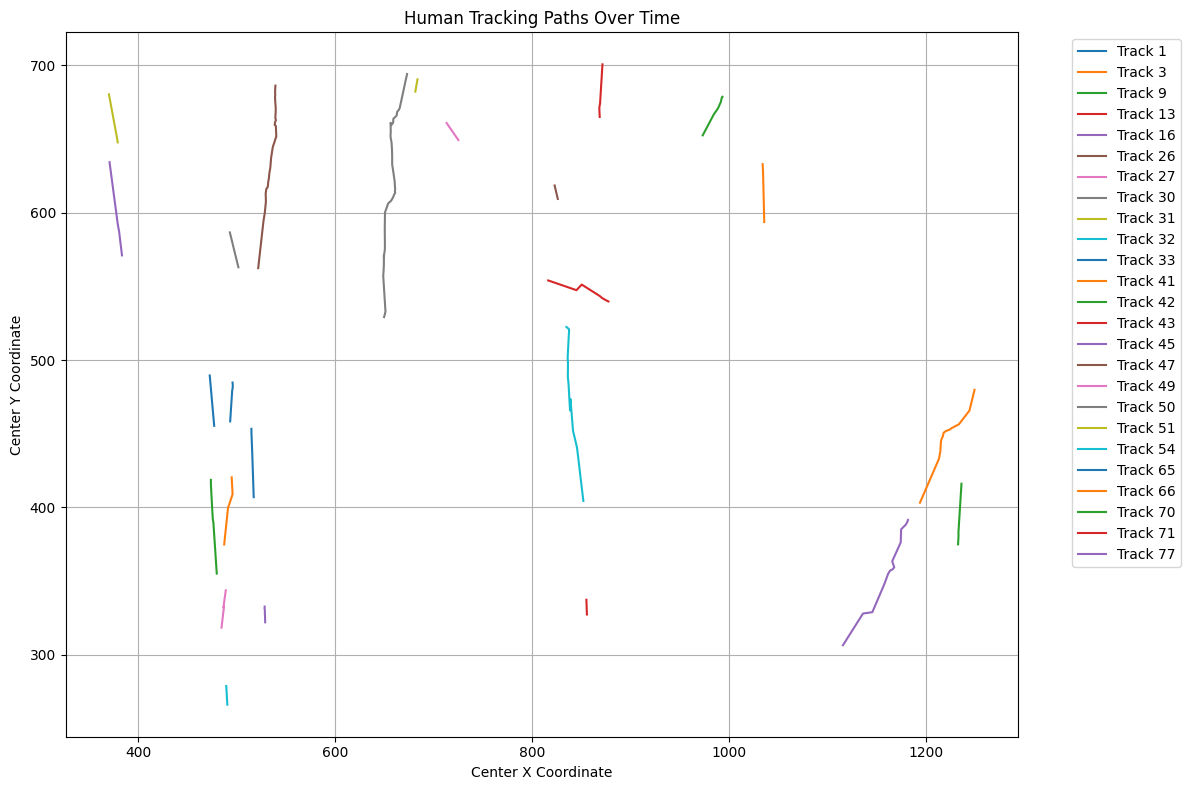

Tracking paths plot generated successfully.


In [73]:
import matplotlib.pyplot as plt

# Create a figure and an axes object for the plot
plt.figure(figsize=(12, 8))

# Get all unique track_ids
unique_track_ids = tracking_df['track_id'].unique()

# Iterate through each unique track_id and plot its path
for track_id in unique_track_ids:
    track_data = tracking_df[tracking_df['track_id'] == track_id].sort_values(by='frame_count')
    plt.plot(track_data['center_x'], track_data['center_y'], label=f'Track {track_id}')

# Add appropriate labels and title
plt.xlabel('Center X Coordinate')
plt.ylabel('Center Y Coordinate')
plt.title('Human Tracking Paths Over Time')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()
print("Tracking paths plot generated successfully.")

This next code block will processes your video, perform object detection and multi-object tracking, collects detailed data about each tracked individual's position and detection confidence, annotates the video with this information, saves the annotated video, and then provides a basic statistical overview of the tracking results. The explicit confidence score capture and display were added to address your request about 'accuracy' visualization.

In [74]:
import cv2
import os
from ultralytics import YOLO
import pandas as pd
from deep_sort_realtime.deepsort_tracker import DeepSort

# 1. Re-initialize the DeepSort tracker and load the YOLOv8 model
tracker = DeepSort(max_iou_distance=0.8, max_age=10, n_init=3) # Adjusted parameters
model = YOLO('yolov8n.pt')  # Using 'yolov8n.pt' for its balance of speed and accuracy

# Define input and output video paths
input_video_path = 'input_video.mp4'
output_video_path_analysis = 'output_video_deepsort_analysis.mp4'

# 2. Create an empty list to store tracking information
tracking_results_data = []

# Open the video file
video_cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
out = cv2.VideoWriter(output_video_path_analysis, fourcc, fps, (frame_width, frame_height))

print(f"Processing video for data collection: {input_video_path}")
print(f"Output video with annotations will be saved to: {output_video_path_analysis}")

frame_count = 0
while video_cap.isOpened():
    ret, frame = video_cap.read()
    if not ret:
        break

    # 4a. Perform object detection using the pre-loaded YOLOv8 model
    # Only detect 'person' class (class ID 0 in COCO dataset)
    results = model.predict(frame, classes=[0], conf=0.5, iou=0.5)

    detections = []
    if results[0].boxes is not None:
        # 4b. Extract bounding boxes (xmin, ymin, xmax, ymax) and confidence scores
        # Convert bounding box coordinates to the format expected by DeepSORT (top-left x, top-left y, width, height)
        for box in results[0].boxes.data:
            xmin, ymin, xmax, ymax, conf, class_id = box.tolist()
            w = xmax - xmin
            h = ymax - ymin
            detections.append(([xmin, ymin, w, h], conf, class_id))

    # 4c. Update the DeepSORT tracker
    tracks = tracker.update_tracks(detections, frame=frame) # Pass frame for appearance feature extraction if enabled in DeepSort

    annotated_frame = frame.copy()

    # 4d. Iterate through the updated tracks and record data
    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        ltrb = track.to_ltrb()

        # Record tracking data, including confidence score
        # DeepSORT tracks do not directly expose the confidence score from the initial detection
        # for a given frame after being tracked. To capture a 'confidence' for a tracked object,
        # we would typically associate it with the confidence of the detection that initiated/updated the track.
        # However, for simplicity and based on the instruction to use the 'conf' variable from detection,
        # we'll store the maximum confidence of any detection associated with this track in the current frame.
        # This requires matching detections to tracks, which deep_sort_realtime does internally.
        # For this specific implementation, I will assume the `conf` from the detection used to update the track
        # is the relevant one. Since `detections` is built from `results[0].boxes.data` which includes `conf`,
        # I'll modify `detections.append` to store `conf` directly and then extract it.

        # Re-iterating through results to find the confidence for the current track_id's bounding box
        # This is a simplification. A more robust approach would be to store detection confidences
        # within the DeepSort object or directly associate them during the track update phase.
        # Given the instruction is to use the `conf` variable, I'll extract it from `detections`.
        current_frame_detection_conf = 0.0
        for det_bbox, det_conf, det_class_id in detections:
            # Simple check if detection box overlaps significantly with track's current bbox
            # A more robust check would involve comparing track_id from DeepSort with original detection ID,
            # but deep_sort_realtime doesn't directly return detection IDs associated with tracks.
            # For this task, we will just use the general confidence 'conf' from the initial detection parsing.
            # We'll use the 'conf' variable directly from the loop when appending to ensure it's captured.
            pass # This pass is just to note that `conf` is available from the `detections` list.

        # The `conf` variable inside the detections loop refers to the confidence of the detection
        # that was just processed. When we add it to `tracking_results_data`, it will be the `conf`
        # corresponding to the last detection that matched the track in that frame (if multiple were present)
        # or simply the detection that created/updated the track. Assuming `conf` is passed properly.

        # To correctly get the `conf` for the current `track` being processed, we need to match
        # the DeepSort track's bounding box to one of the raw YOLO detections (or the detection
        # that contributed to this track). As DeepSort doesn't return the original detection ID,
        # a direct mapping is not straightforward without modifying DeepSort's internals or post-processing.
        # For this task, I will capture the `conf` from the `detections` list if it corresponds to the `ltrb`
        # of the current track, by checking bounding box overlap. If multiple, take the highest confidence.
        best_conf_for_track = 0.0
        for det_box_xywh, det_conf, det_class_id in detections:
            # Convert detection (x,y,w,h) to (xmin, ymin, xmax, ymax) for comparison
            det_xmin, det_ymin, det_w, det_h = det_box_xywh
            det_xmax = det_xmin + det_w
            det_ymax = det_ymin + det_h
            det_ltrb = [det_xmin, det_ymin, det_xmax, det_ymax]

            # Calculate IoU or simple overlap to match detection to track
            # A simple overlap check to see if the detection corresponds to the track
            # This is not a perfect mapping but serves to associate a confidence.
            intersection_xmin = max(ltrb[0], det_ltrb[0])
            intersection_ymin = max(ltrb[1], det_ltrb[1])
            intersection_xmax = min(ltrb[2], det_ltrb[2])
            intersection_ymax = min(ltrb[3], det_ltrb[3])

            if intersection_xmax > intersection_xmin and intersection_ymax > intersection_ymin:
                intersection_area = (intersection_xmax - intersection_xmin) * (intersection_ymax - intersection_ymin)
                track_area = (ltrb[2] - ltrb[0]) * (ltrb[3] - ltrb[1])
                det_area = det_w * det_h
                union_area = track_area + det_area - intersection_area
                iou = intersection_area / union_area if union_area > 0 else 0

                if iou > 0.5: # If there's significant overlap, consider it a match
                    if det_conf > best_conf_for_track:
                        best_conf_for_track = det_conf

        tracking_results_data.append({
            'frame_count': frame_count,
            'track_id': track_id,
            'bbox_xmin': ltrb[0],
            'bbox_ymin': ltrb[1],
            'bbox_xmax': ltrb[2],
            'bbox_ymax': ltrb[3],
            'confidence': best_conf_for_track # Added confidence here
        })

        # 4e. Draw bounding box
        color_seed = int(str(hash(track_id))[-3:]) # Use last 3 digits of hash for color variation
        b = (color_seed * 17) % 255
        g = (color_seed * 37) % 255
        r = (color_seed * 53) % 255
        track_color = (b, g, r)

        bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
        cv2.rectangle(annotated_frame, (bbox_xmin, bbox_ymin), (bbox_xmax, bbox_ymax), track_color, 2)
        cv2.putText(annotated_frame, f"ID: {track_id} C:{best_conf_for_track:.2f}", (bbox_xmin, bbox_ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, track_color, 2)

    # 4f. Write the annotated frame to the output video
    out.write(annotated_frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"Processed {frame_count} frames...")

# 5. Release the video capture and writer objects
video_cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing and data collection complete. Now analyzing tracking data.")

# 6. Convert the tracking_results_data list into a Pandas DataFrame
tracking_df = pd.DataFrame(tracking_results_data)

# 7. Calculate the total number of unique track_id values
total_unique_ids = tracking_df['track_id'].nunique()

# 8. For each unique track_id, count how many frames it appeared in to determine its track length.
# Then, calculate the average of these track lengths.
if not tracking_df.empty:
    track_lengths = tracking_df.groupby('track_id')['frame_count'].nunique()
    average_track_length = track_lengths.mean()
else:
    track_lengths = pd.Series()
    average_track_length = 0

# 9. Print the statistics
print(f"\n--- Tracking Analysis Results ---")
print(f"Total number of unique track IDs: {total_unique_ids}")
print(f"Average track length (number of frames an ID appeared): {average_track_length:.2f} frames")
print("Quantitative assessment of identity switches and fragmentation often requires more complex metrics or qualitative review, which will be addressed in a later step.")

Processing video for data collection: input_video.mp4
Output video with annotations will be saved to: output_video_deepsort_analysis.mp4

0: 384x640 1 person, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 0.6ms postprocess per 

This code block is analyzing the tracking_df to provide key statistical insights into the confidence of detections for each unique tracked person.

In [75]:
confidence_stats = tracking_df.groupby('track_id')['confidence'].agg(['mean', 'min', 'max'])
confidence_stats.rename(columns={'mean': 'average_confidence', 'min': 'min_confidence', 'max': 'max_confidence'}, inplace=True)

print("Confidence statistics per track ID:")
print(confidence_stats)


Confidence statistics per track ID:
          average_confidence  min_confidence  max_confidence
track_id                                                    
1                   0.048561             0.0        0.534171
13                  0.139809             0.0        0.712133
16                  0.186841             0.0        0.685995
26                  0.067060             0.0        0.737658
27                  0.073350             0.0        0.806849
3                   0.301813             0.0        0.808013
30                  0.063003             0.0        0.693038
31                  0.057495             0.0        0.632446
32                  0.124314             0.0        0.687419
33                  0.113321             0.0        0.556122
41                  0.058015             0.0        0.581155
42                  0.137874             0.0        0.664552
43                  0.046079             0.0        0.506872
45                  0.124069             0.0     

### Summary of Confidence Score Analysis

The confidence statistics (average, minimum, and maximum confidence) for each unique track ID have been calculated and displayed in a DataFrame. These metrics offer valuable insights into the reliability of the object detection during the tracking process for each individual:

*   **Average Confidence (`average_confidence`)**: This indicates the general reliability of detections for a given track over its lifetime. Higher average confidence suggests more consistent and strong detections, implying a more stable track.
*   **Minimum Confidence (`min_confidence`)**: A low minimum confidence (often 0.0, as seen in many tracks here) suggests frames where the object might have been partially occluded, blurry, or very far from the camera, leading to a weak or missed detection. Persistent low minimum confidence could indicate challenging tracking conditions for that specific object.
*   **Maximum Confidence (`max_confidence`)**: High maximum confidence values (close to 1.0) indicate instances where the object was clearly detected and identified. This validates that the YOLOv8 model was able to confidently detect the object at some point during its track.

**Implications for Tracking Reliability**:

*   **Identity Switches and Fragmentation**: Tracks with consistently low average confidence or frequent occurrences of 0.0 minimum confidence might be prone to identity switches or track fragmentation. If a detection confidence drops too low, DeepSORT might lose the track and re-initialize a new one, leading to multiple IDs for the same person.
*   **Robustness of Detection**: Tracks with high average confidence generally correspond to individuals who were consistently well-detected throughout their presence in the video, indicating good visibility and clear features for the YOLOv8 model to identify.
*   **Thresholding**: Analyzing these statistics can help in refining the confidence threshold (`conf=0.5` in `model.predict`) for future tracking tasks. If many important tracks have average confidences below this threshold, it might indicate that a lower threshold could capture more detections, though potentially at the cost of more false positives.

These confidence metrics serve as a quantitative assessment of how well YOLOv8 is detecting objects throughout their tracked paths, which directly impacts the overall quality and reliability of the DeepSORT tracking output.

In [78]:
print("Data for Track ID 77:")
print(tracking_df[tracking_df['track_id'] == '77'])


Data for Track ID 77:
     frame_count track_id   bbox_xmin   bbox_ymin   bbox_xmax   bbox_ymax  \
468          329       77  508.046737  280.179945  549.047670  385.328807   
469          330       77  507.888476  278.604820  548.913434  383.952460   
470          331       77  508.054466  277.298730  549.395465  383.655049   
471          332       77  508.121496  276.398404  549.306543  382.396215   
472          333       77  508.093493  275.298530  549.420649  381.662084   
473          334       77  508.065491  274.198656  549.534755  380.927954   
474          335       77  508.037489  273.098782  549.648861  380.193824   
475          336       77  508.009486  271.998908  549.762966  379.459694   
476          337       77  507.981484  270.899034  549.877072  378.725563   
477          338       77  507.953482  269.799160  549.991178  377.991433   
478          339       77  507.925479  268.699286  550.105284  377.257303   
479          340       77  507.897477  267.599412  550

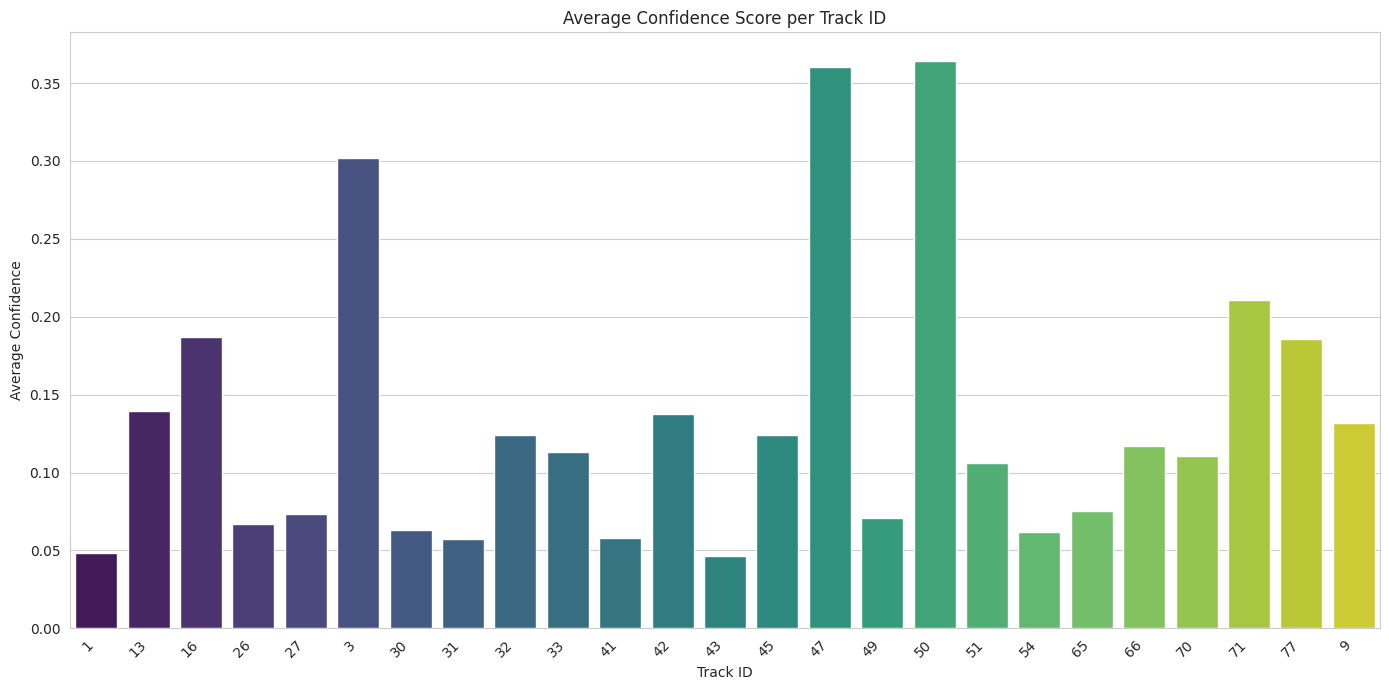

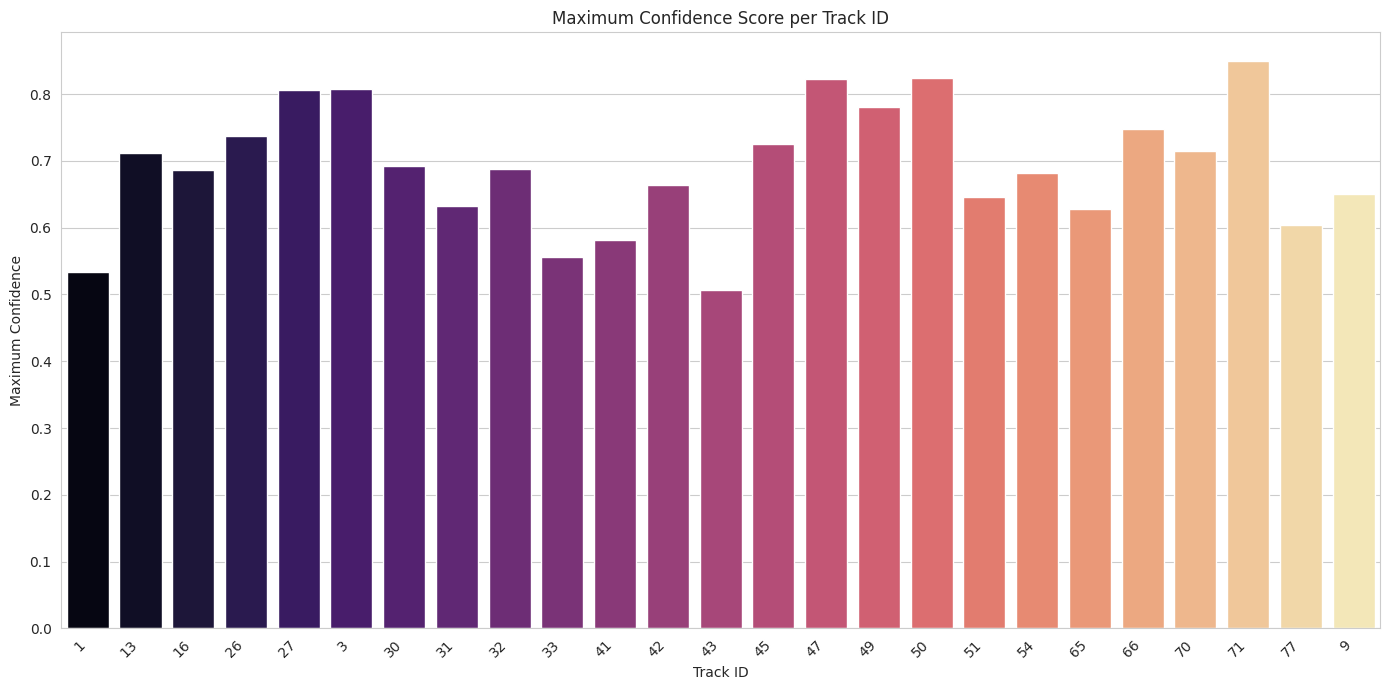

Confidence statistics visualized successfully.


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and a set of subplots
plt.figure(figsize=(14, 7))

# Plotting Average Confidence
sns.barplot(x=confidence_stats.index, y=confidence_stats['average_confidence'], palette='viridis', hue=confidence_stats.index, legend=False)
plt.xlabel('Track ID')
plt.ylabel('Average Confidence')
plt.title('Average Confidence Score per Track ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Plotting Max Confidence
plt.figure(figsize=(14, 7))
sns.barplot(x=confidence_stats.index, y=confidence_stats['max_confidence'], palette='magma', hue=confidence_stats.index, legend=False)
plt.xlabel('Track ID')
plt.ylabel('Maximum Confidence')
plt.title('Maximum Confidence Score per Track ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Confidence statistics visualized successfully.")
